In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from typing import Tuple
import sys
import pandas as pd
import ast
from Enum.Flavour import Flavour
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
matplotlib.use("Agg")

sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam(isVaryLineStyle=False)
from InferenceUtil import *
%matplotlib inline

In [15]:
"""
{TrainID:{epoch:csv_name}}
"""

prediction_base_csv_name = {
    "base" : "/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/",
    25: {
        "inter" : "20250527/model_20250521_122145/150458/",
        17 : "predictions_epoch_17_val_loss_0.109.csv",
        19 : "predictions_epoch_19_val_loss_0.110.csv",
        20 : "predictions_epoch_20.csv",
        21 : "predictions_epoch_21_val_loss_0.110.csv",
        23 : "predictions_epoch_23.csv",
        26 : "predictions_epoch_26.csv",
        29 : "predictions_epoch_29.csv",
        32 : "predictions_epoch_32.csv",
        35 : "predictions_epoch_35.csv",
        49: "predictions_epoch_last.csv"
    },
    30: { # done!
        "note": "32 features",
        "inter" : "20250528/model_20250525_234823/201541/",
        17 : "predictions_epoch_17.csv",
        19 : "predictions_epoch_19_val_loss_0.110.csv",
        20 : "predictions_epoch_20.csv",
        21 : "predictions_epoch_21_val_loss_0.110.csv",
        23 : "predictions_epoch_23.csv",
        26 : "predictions_epoch_26.csv",
        29 : "predictions_epoch_29.csv",
        32 : "predictions_epoch_32.csv",
        35 : "predictions_epoch_35.csv",
        49: "predictions_epoch_last.csv"
    },
    40: { # done!
        "note" : "track vs cascade",
        "inter" : "/20250528/model_20250525_085820/223938/",
        17 : "predictions_epoch_17_val_loss_0.109.csv",
        19 : "predictions_epoch_19_val_loss_0.110.csv",
        20 : "predictions_epoch_20.csv",
        21 : "predictions_epoch_21_val_loss_0.110.csv",
        23 : "predictions_epoch_23.csv",
        26 : "predictions_epoch_26.csv",
        29 : "predictions_epoch_29.csv",
        32 : "predictions_epoch_32.csv",
        35 : "predictions_epoch_35.csv",
        49: "predictions_epoch_last.csv"
    },
    50: { # done!
        "note" : "signal vs noise",
        "inter" : "/20250529/model_20250526_172743/004836/",
        17 : "predictions_epoch_17_val_loss_0.109.csv",
        19 : "predictions_epoch_19_val_loss_0.110.csv",
        20 : "predictions_epoch_20.csv",
        21 : "predictions_epoch_21_val_loss_0.110.csv",
        23 : "predictions_epoch_23.csv",
        26 : "predictions_epoch_26.csv",
        29 : "predictions_epoch_29.csv",
        32 : "predictions_epoch_32.csv",
        35 : "predictions_epoch_35.csv",
        49: "predictions_epoch_last.csv"
    },
    60: { # done!
        "note" : "contain",
        "inter" : "/20250529/model_20250529_013554/151354/",
        14: "predictions_epoch_14_val_loss_0.113.csv",
        15 : "predictions_epoch_15_val_loss_0.112.csv",
        17 : "predictions_epoch_17.csv",
        18: "predictions_epoch_18_val_loss_0.114.csv",
        20 : "predictions_epoch_20.csv",
        23 : "predictions_epoch_23.csv",
        26 : "predictions_epoch_26.csv",
        29 : "predictions_epoch_29.csv",
        32 : "predictions_epoch_32.csv",
        35 : "predictions_epoch_35.csv",
        49: "predictions_epoch_last.csv"
    },
    61: { # done!
        "note" : "contain, 2048",
        "inter" : "/20250529/model_20250529_013554/233810/",
        15: "predictions_epoch_15_val_loss_0.112.csv",
        17: "predictions_epoch_17_val_loss_0.113.csv",
        18: "predictions_epoch_18_val_loss_0.114.csv",
        20 : "predictions_epoch_20.csv",
        23: "predictions_epoch_23.csv",
        26 : "predictions_epoch_26.csv",
        29 : "predictions_epoch_29.csv",
        32 : "predictions_epoch_32.csv",
        35 : "predictions_epoch_35.csv",
        49: "predictions_epoch_last.csv"
    },
}

In [16]:
def build_csv_name(train_id: int, epoch: int) -> str:
    if train_id not in prediction_base_csv_name:
        raise ValueError(f"Train ID {train_id} not found in prediction_base_csv_name.")
    if epoch not in prediction_base_csv_name[train_id]:
        raise ValueError(f"Epoch {epoch} not found for Train ID {train_id}.")
    inter = prediction_base_csv_name[train_id]["inter"]
    csv_name = prediction_base_csv_name[train_id][epoch]
    full_path = f"{prediction_base_csv_name['base']}{inter}{csv_name}"
    return full_path

In [17]:
def plot_binary_flavour_ROC(df: pd.DataFrame, signal_flavour: Flavour, id: str) -> None:
    fig, ax = plt.subplots(figsize=(17, 11))
    nu_e_prob, nu_mu_prob, nu_tau_prob = get_nu_prob(df, signal_flavour)

    all_outputs = {
        Flavour.E: nu_e_prob,
        Flavour.MU: nu_mu_prob,
        Flavour.TAU: nu_tau_prob
    }

    y_true = []
    y_score = []

    for flavour, output in all_outputs.items():
        y_true.append(np.ones_like(output) if flavour == signal_flavour else np.zeros_like(output))
        y_score.append(output)

    y_true = np.concatenate(y_true)
    y_score = np.concatenate(y_score)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    # make a residual flavour name list, by excluding the signal flavour from all_logits.keys()
    residual_flavours = [flavour for flavour in all_outputs.keys() if flavour != signal_flavour]
    label_roc = (
        fr"$\bf{signal_flavour.latex}$ vs "
        fr"(${residual_flavours[0].latex}$+${residual_flavours[1].latex}$)"
        + "\n" + f"AUC = {roc_auc:.3f}"
    )
    set_colour = getColour(2) if signal_flavour == Flavour.E else getColour(0) if signal_flavour == Flavour.MU else getColour(1)
    ax.plot(fpr, tpr, linewidth=2, color=set_colour, markersize=1, label=label_roc)

    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=24)
    ax.set_ylabel('True Positive Rate', fontsize=24)
    ax.set_title(fr"{id}: ${signal_flavour.latex}$ vs (${residual_flavours[0].latex}$+${residual_flavours[1].latex}$)")
    ax.legend(loc="lower right", fontsize=24)
    plt.tight_layout()
    plt.show()

In [18]:
def plot_ROC(train_id: int, epoch: int):
    id = f"TrainID {train_id} Epoch {epoch}"
    df = pd.read_csv(build_csv_name(train_id, epoch))
    plot_multi_flavour_ROC(df, id)

In [19]:
def plot_prob(train_id: int, epoch: int):
    id = f"TrainID {train_id} Epoch {epoch}"
    df = pd.read_csv(build_csv_name(train_id, epoch))
    plot_prob_distribution_with_truncation(df, Flavour.TAU, id, [0.9,1.0])
    plot_prob_distribution_with_truncation(df, Flavour.TAU, id)
    plot_prob_distribution_with_truncation(df, Flavour.MU, id, [0.8,1.0])
    plot_prob_distribution_with_truncation(df, Flavour.MU, id)
    plot_prob_distribution_with_truncation(df, Flavour.E, id, [0.8,1.0])
    plot_prob_distribution_with_truncation(df, Flavour.E, id)

In [20]:
def plot_energy(train_id: int, epoch: int):
    id = f"TrainID {train_id} Epoch {epoch}"
    df = pd.read_csv(build_csv_name(train_id, epoch))
    plot_energy_distribution(df, Flavour.TAU, Flavour.TAU, id)
    plot_energy_distribution(df, Flavour.MU, Flavour.MU, id)
    plot_energy_distribution(df, Flavour.E, Flavour.E, id)

In [21]:
def plot_zenith(train_id: int, epoch: int):
    id = f"TrainID {train_id} Epoch {epoch}"
    df = pd.read_csv(build_csv_name(train_id, epoch))
    plot_zenith_distribution(df, Flavour.TAU, Flavour.TAU, id)
    plot_zenith_distribution(df, Flavour.MU, Flavour.MU, id)
    plot_zenith_distribution(df, Flavour.E, Flavour.E, id)

In [22]:
def get_em_all(train_id: int, epoch: int):
    plot_prob(train_id, epoch)
    plot_ROC(train_id, epoch)
    plot_energy(train_id, epoch)
    plot_zenith(train_id, epoch)


In [23]:
# get_em_all(25,23)

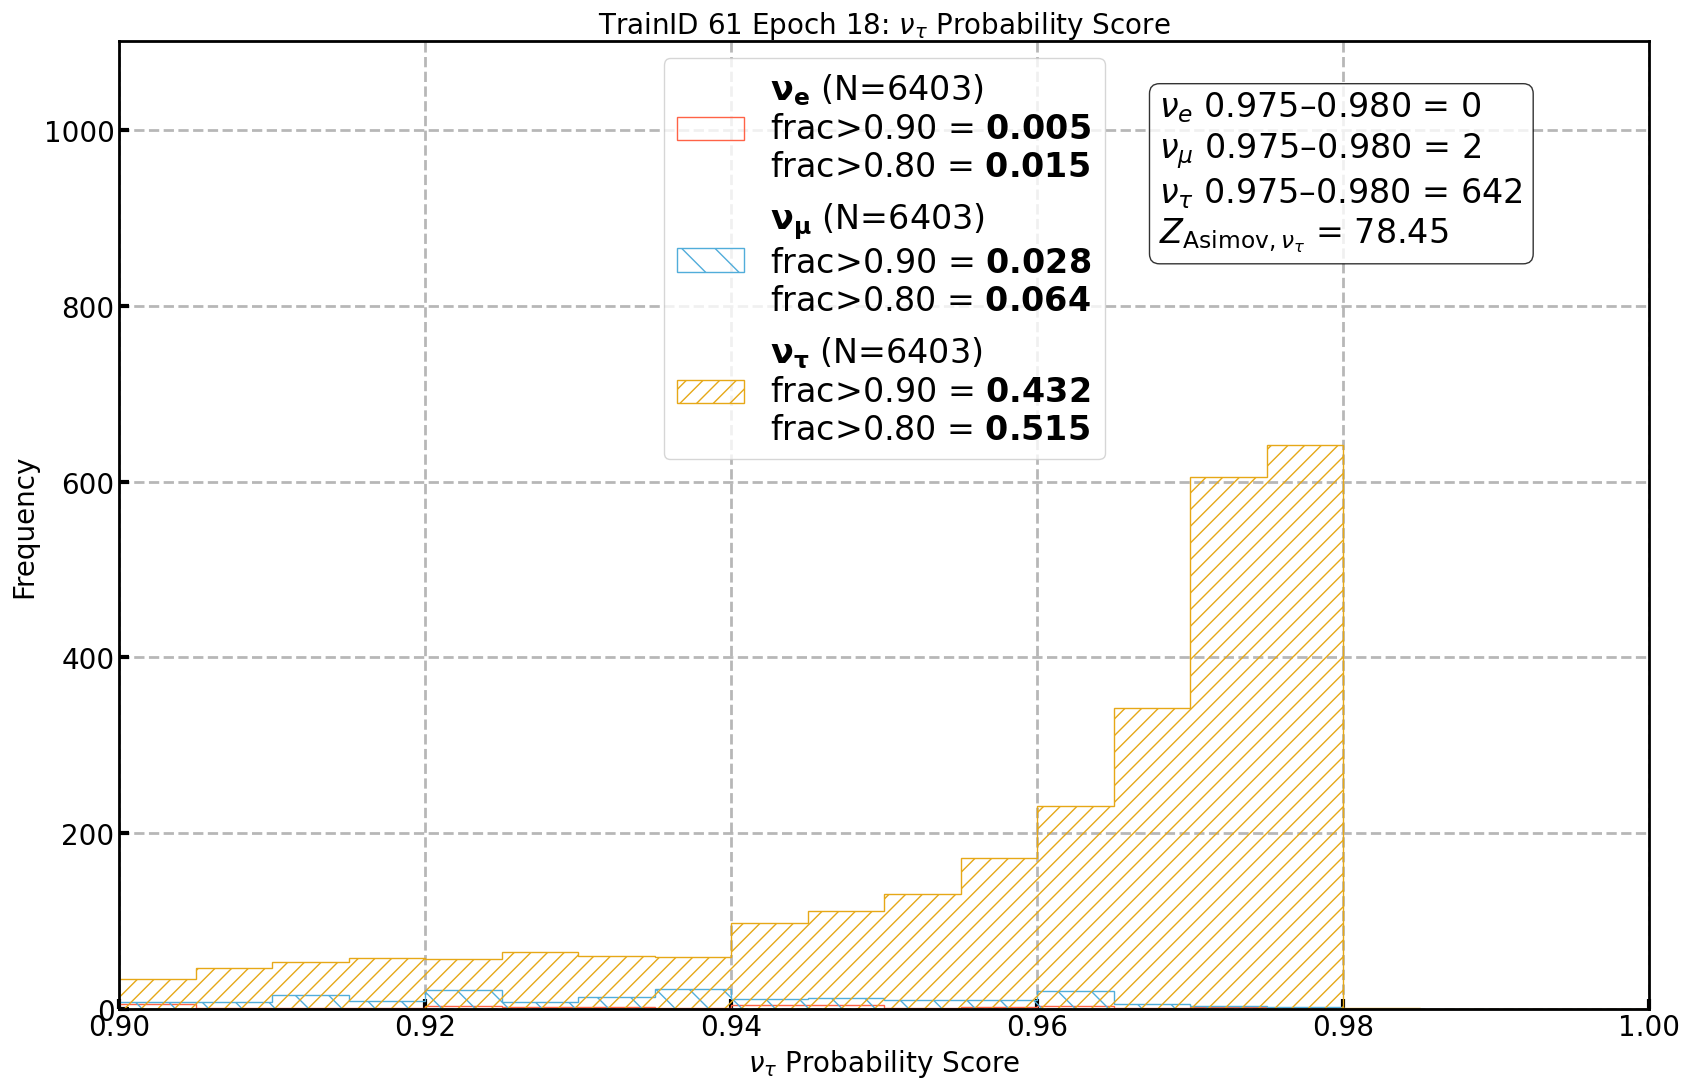

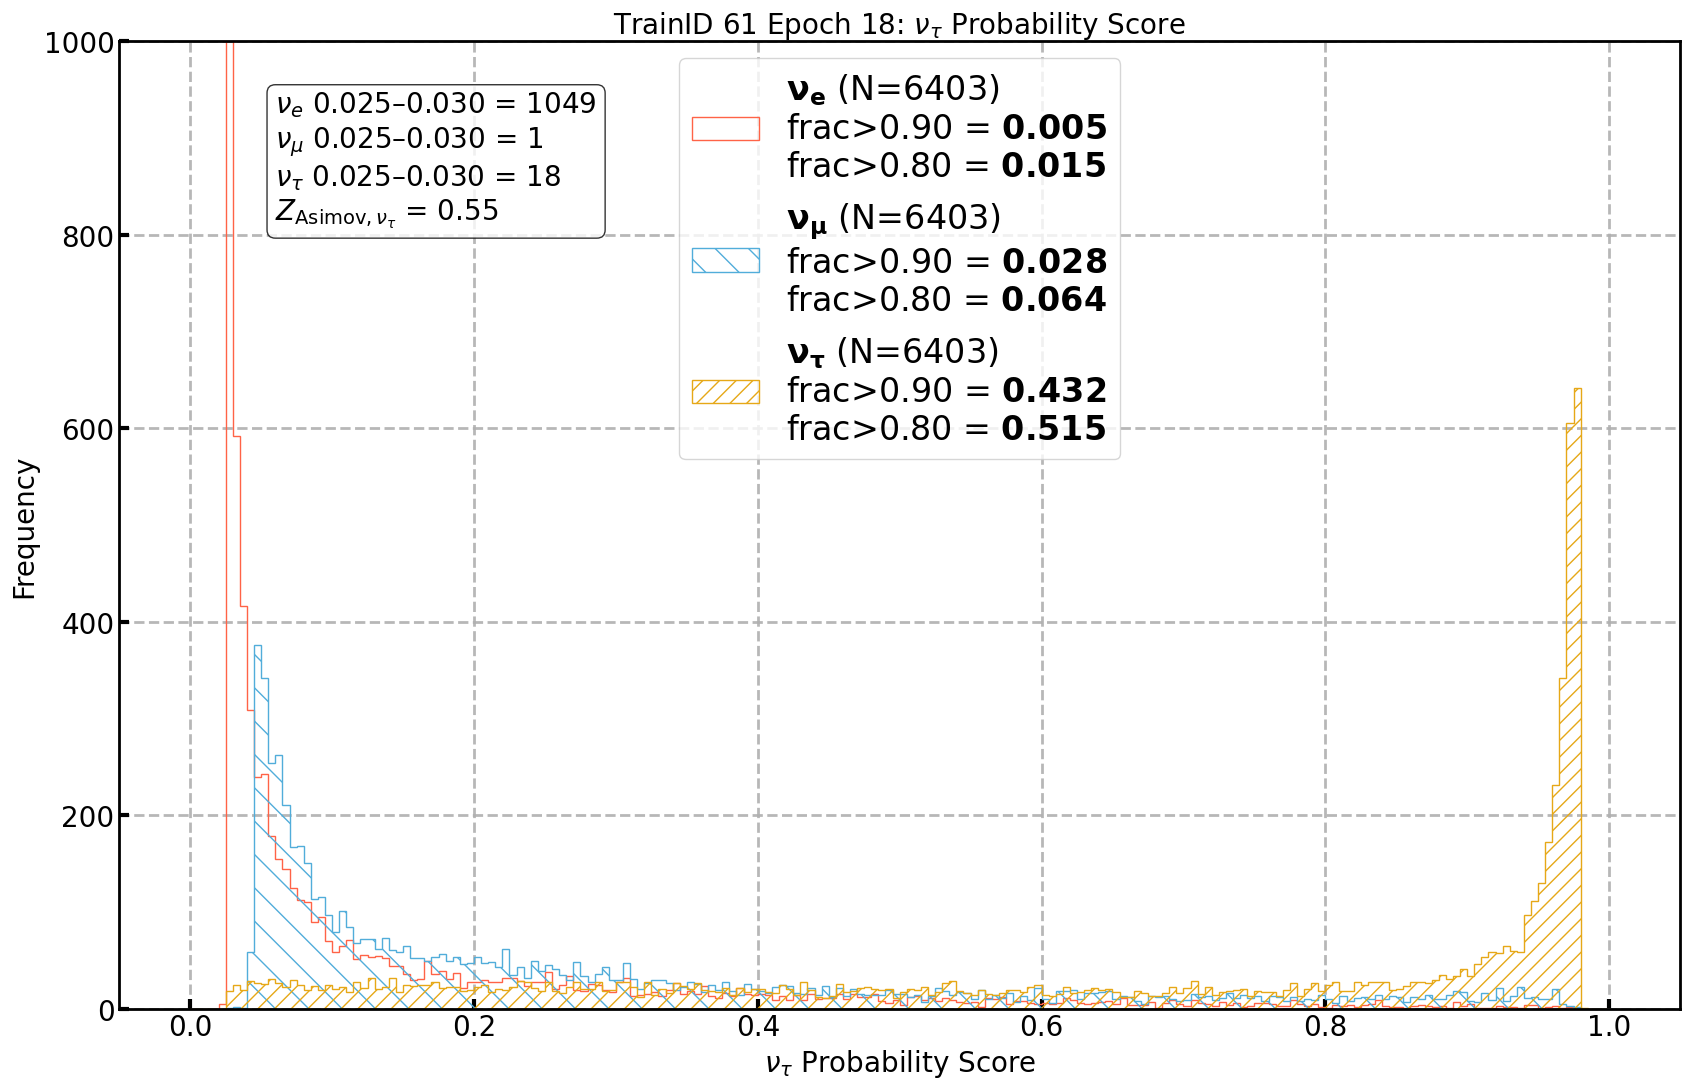

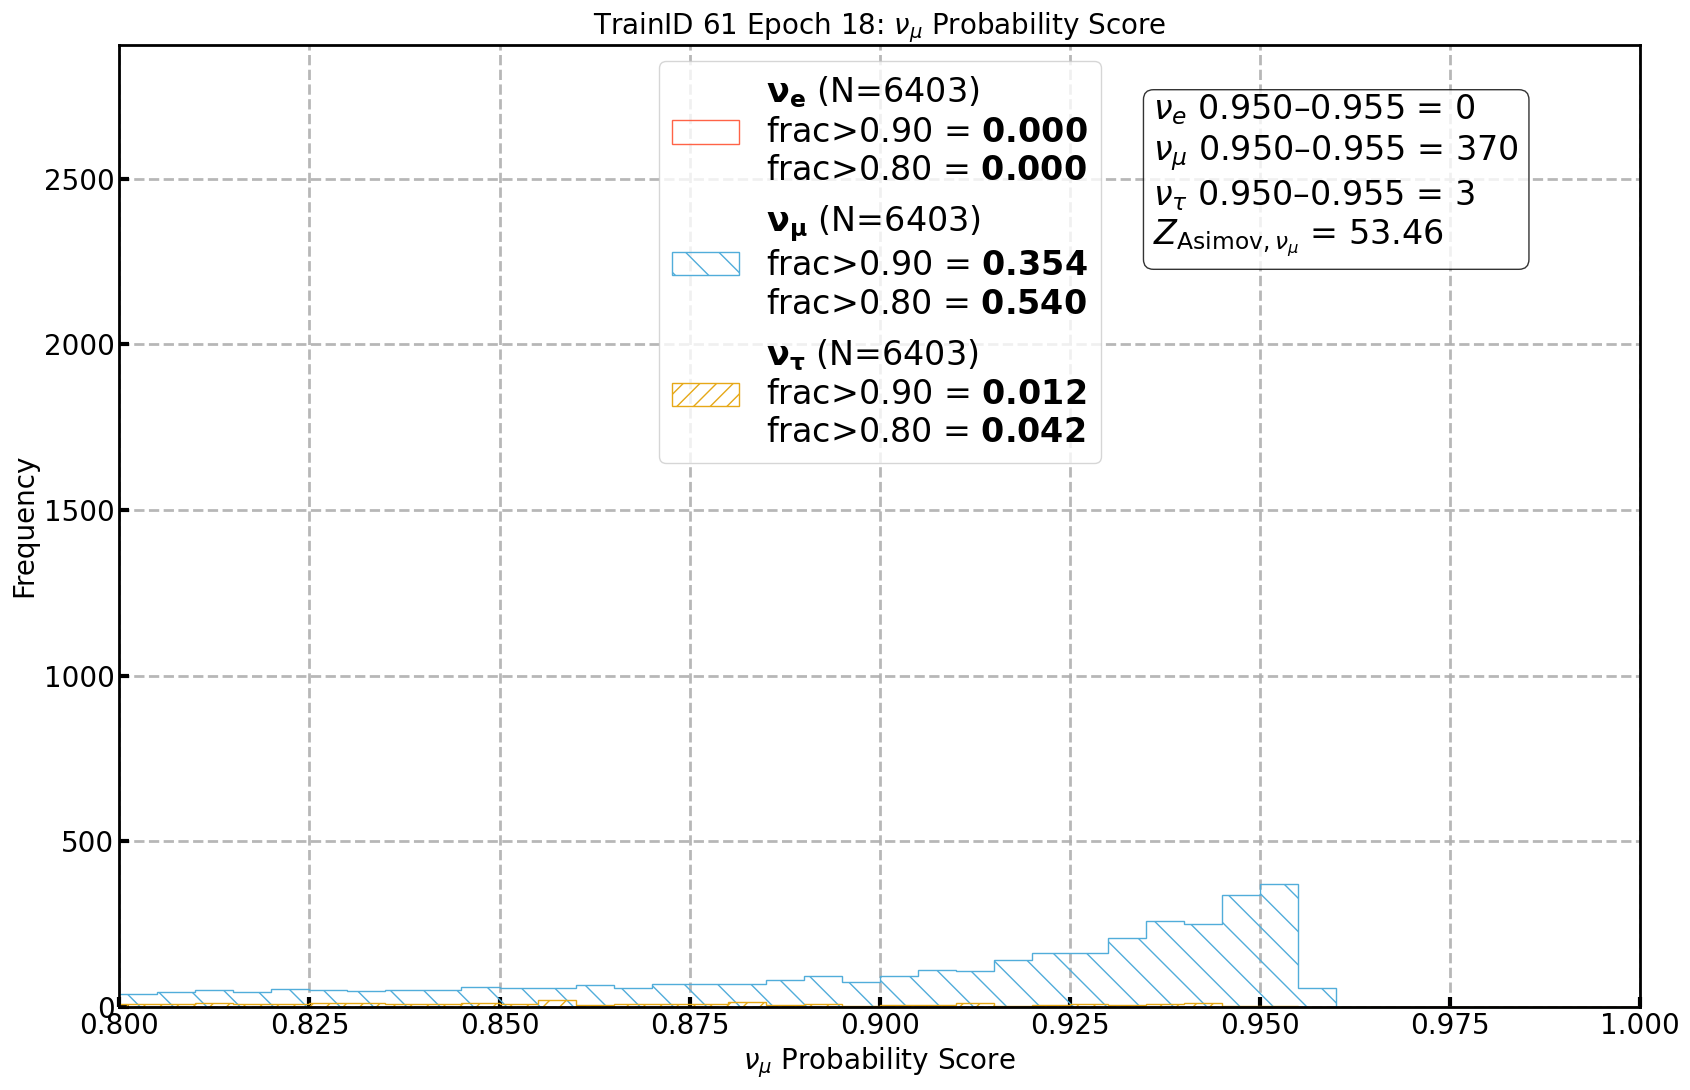

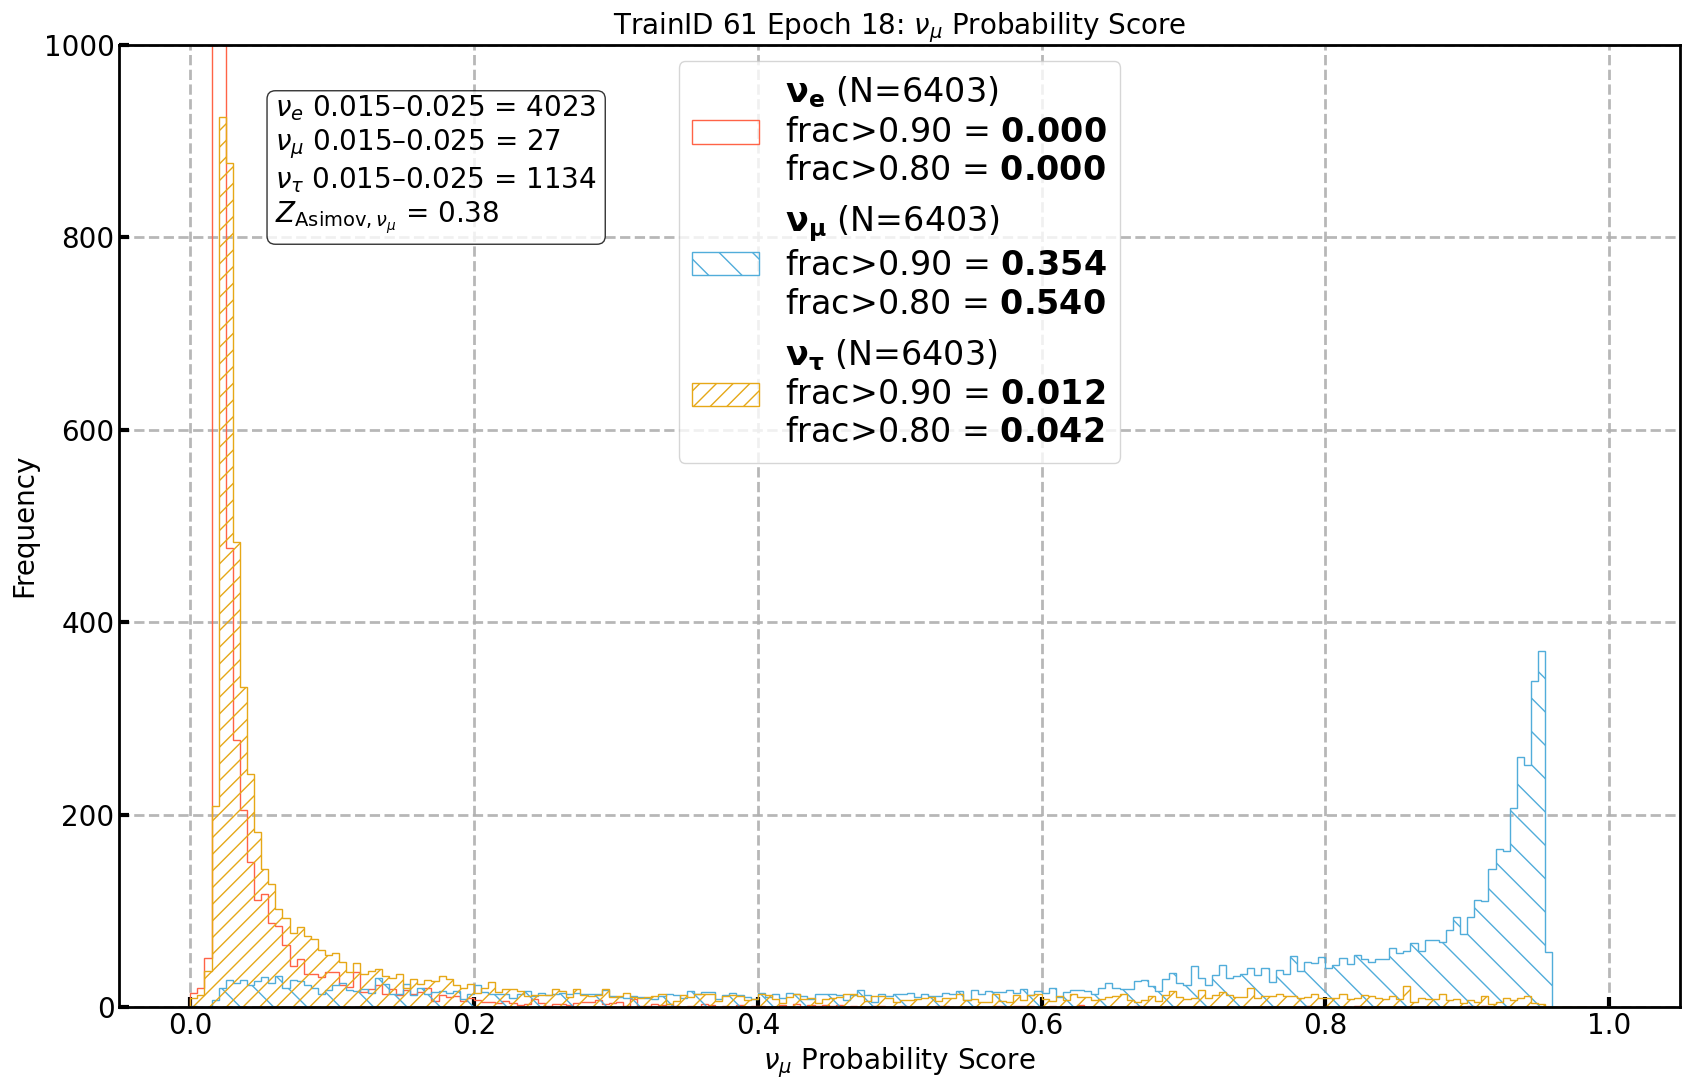

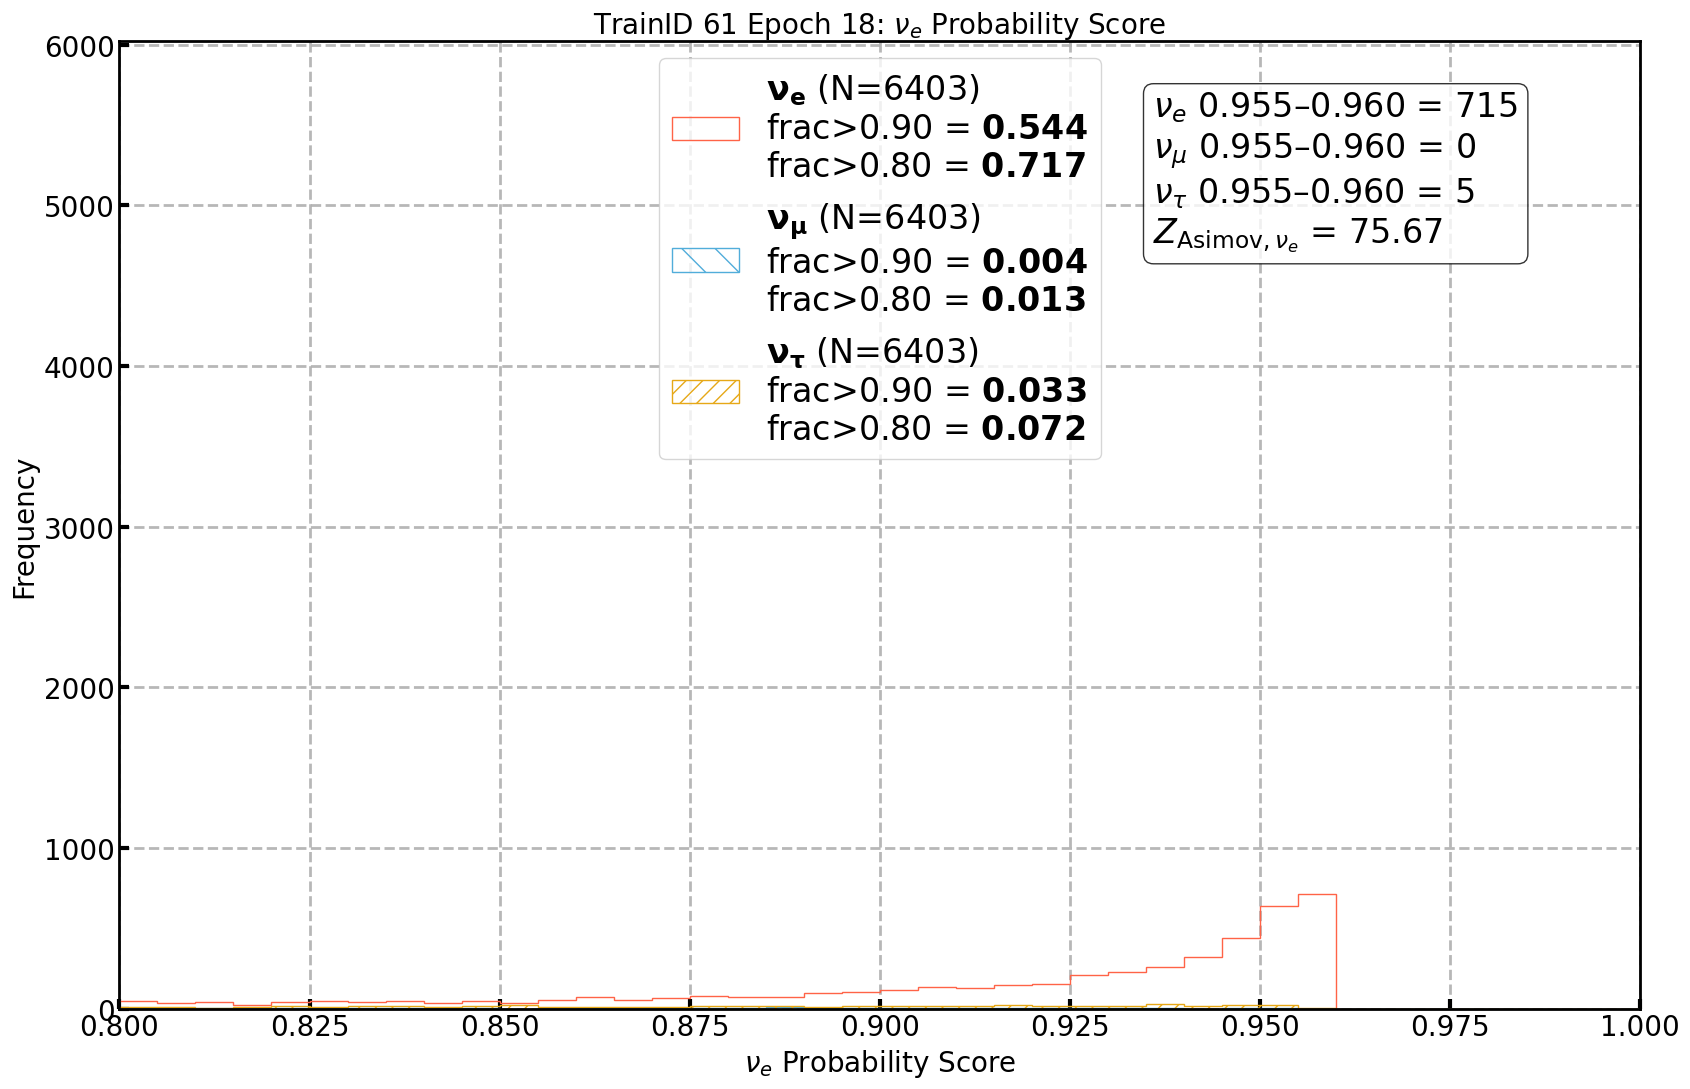

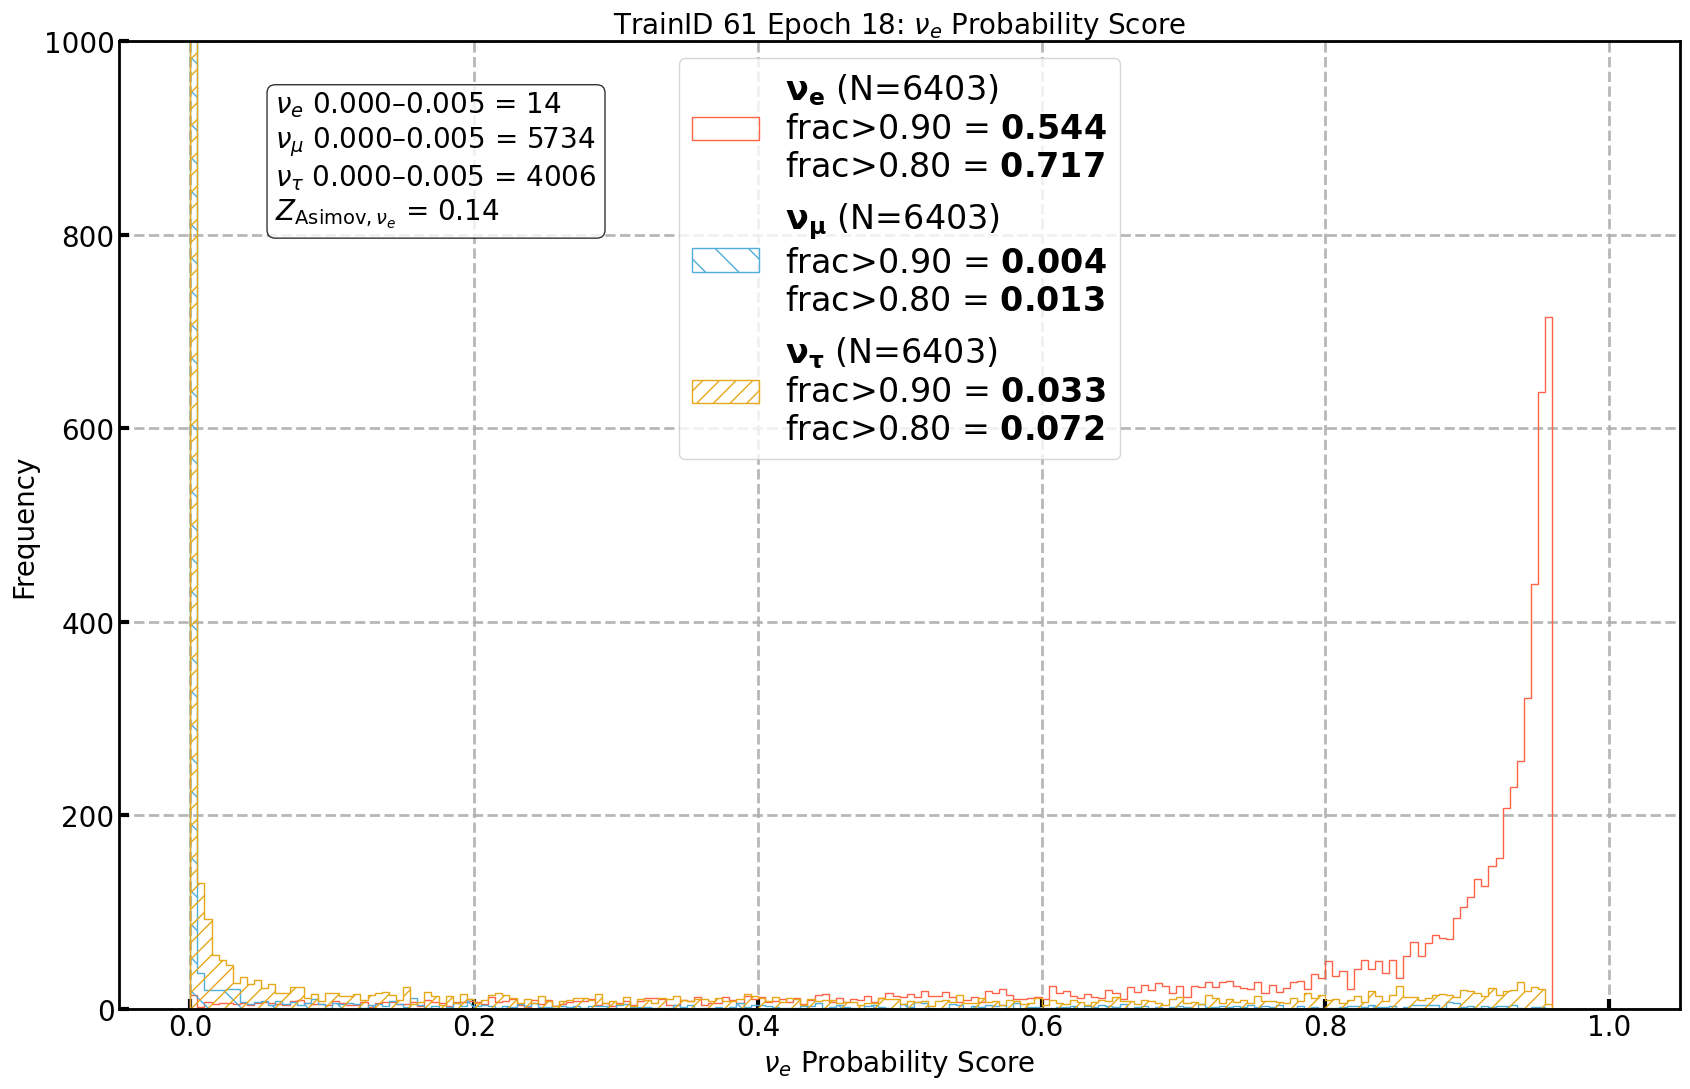

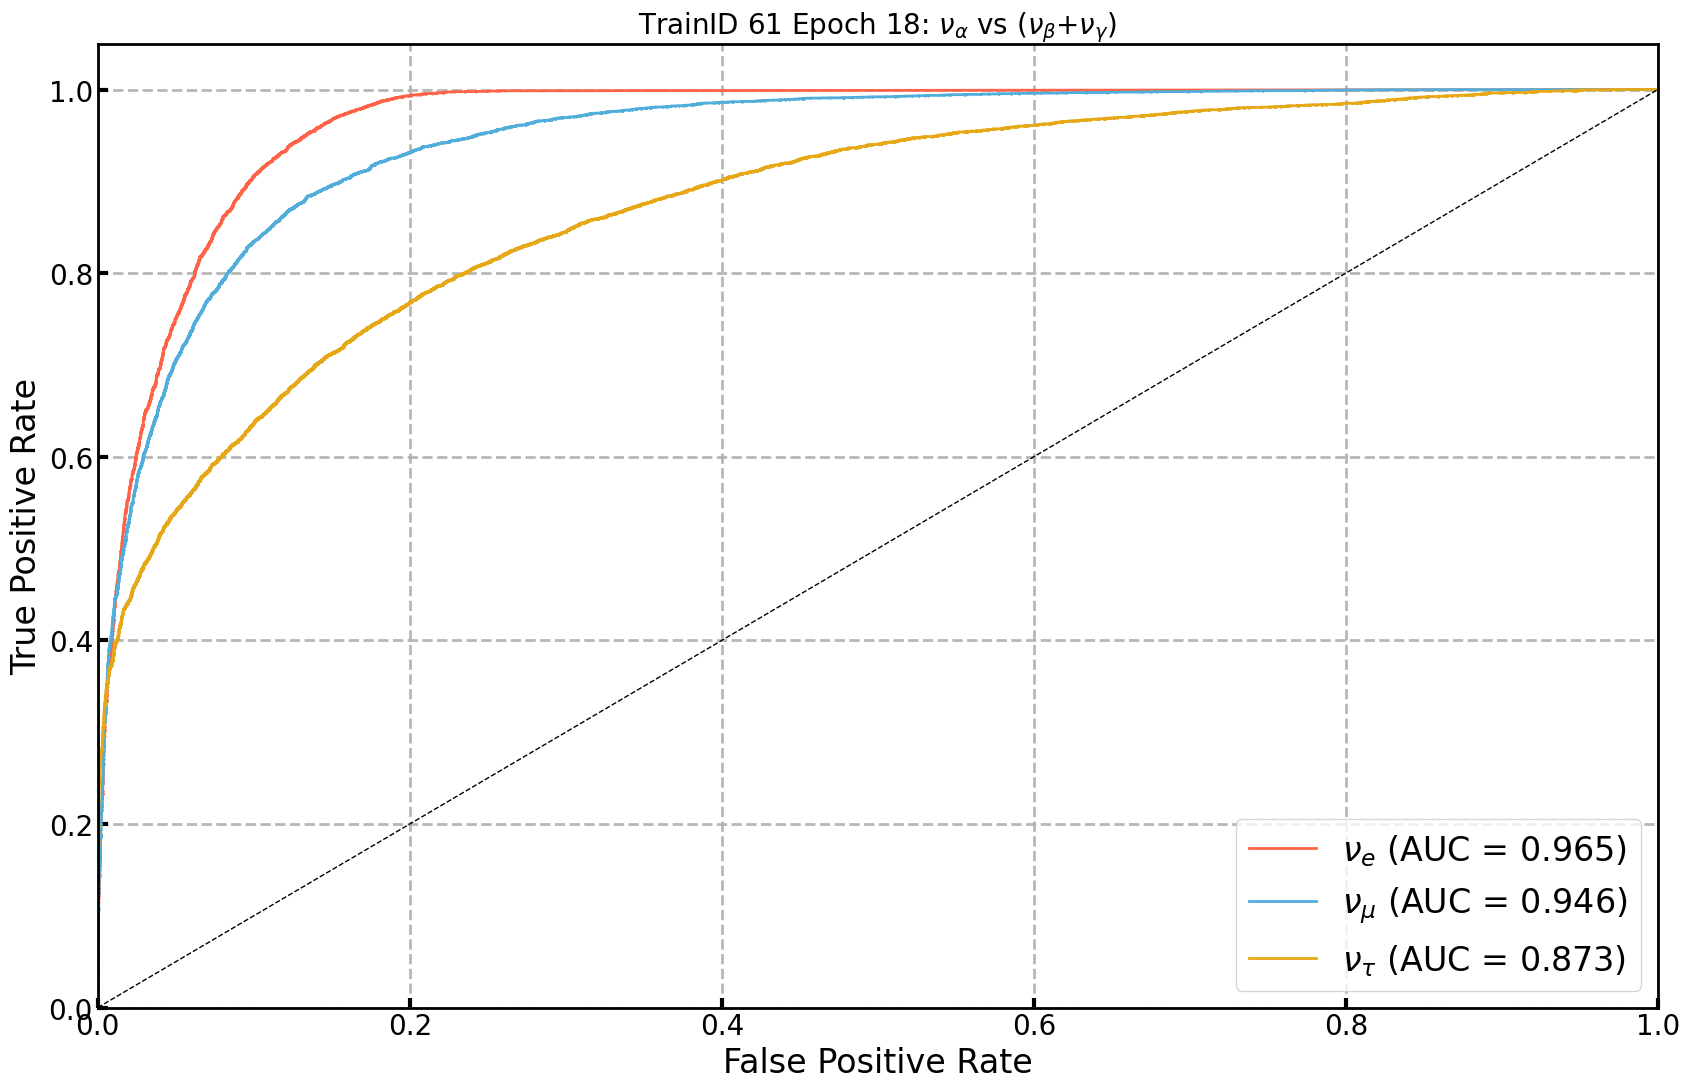

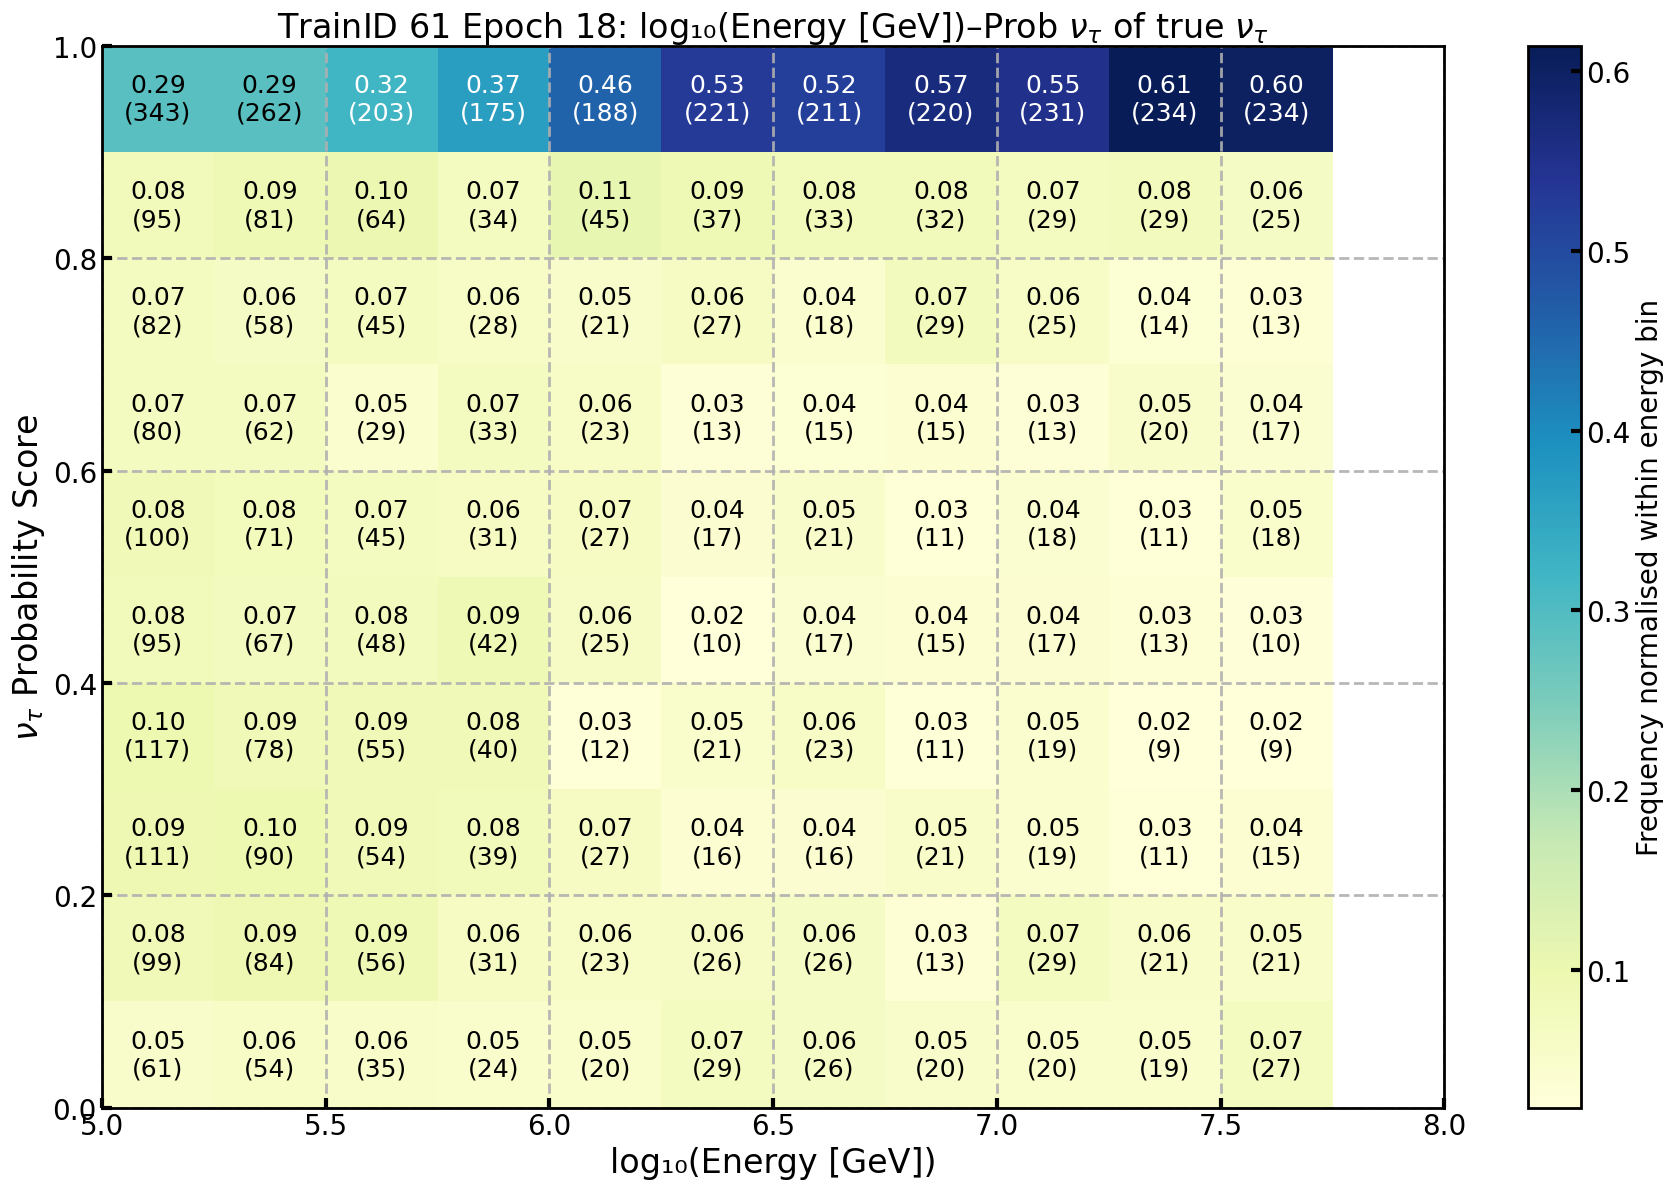

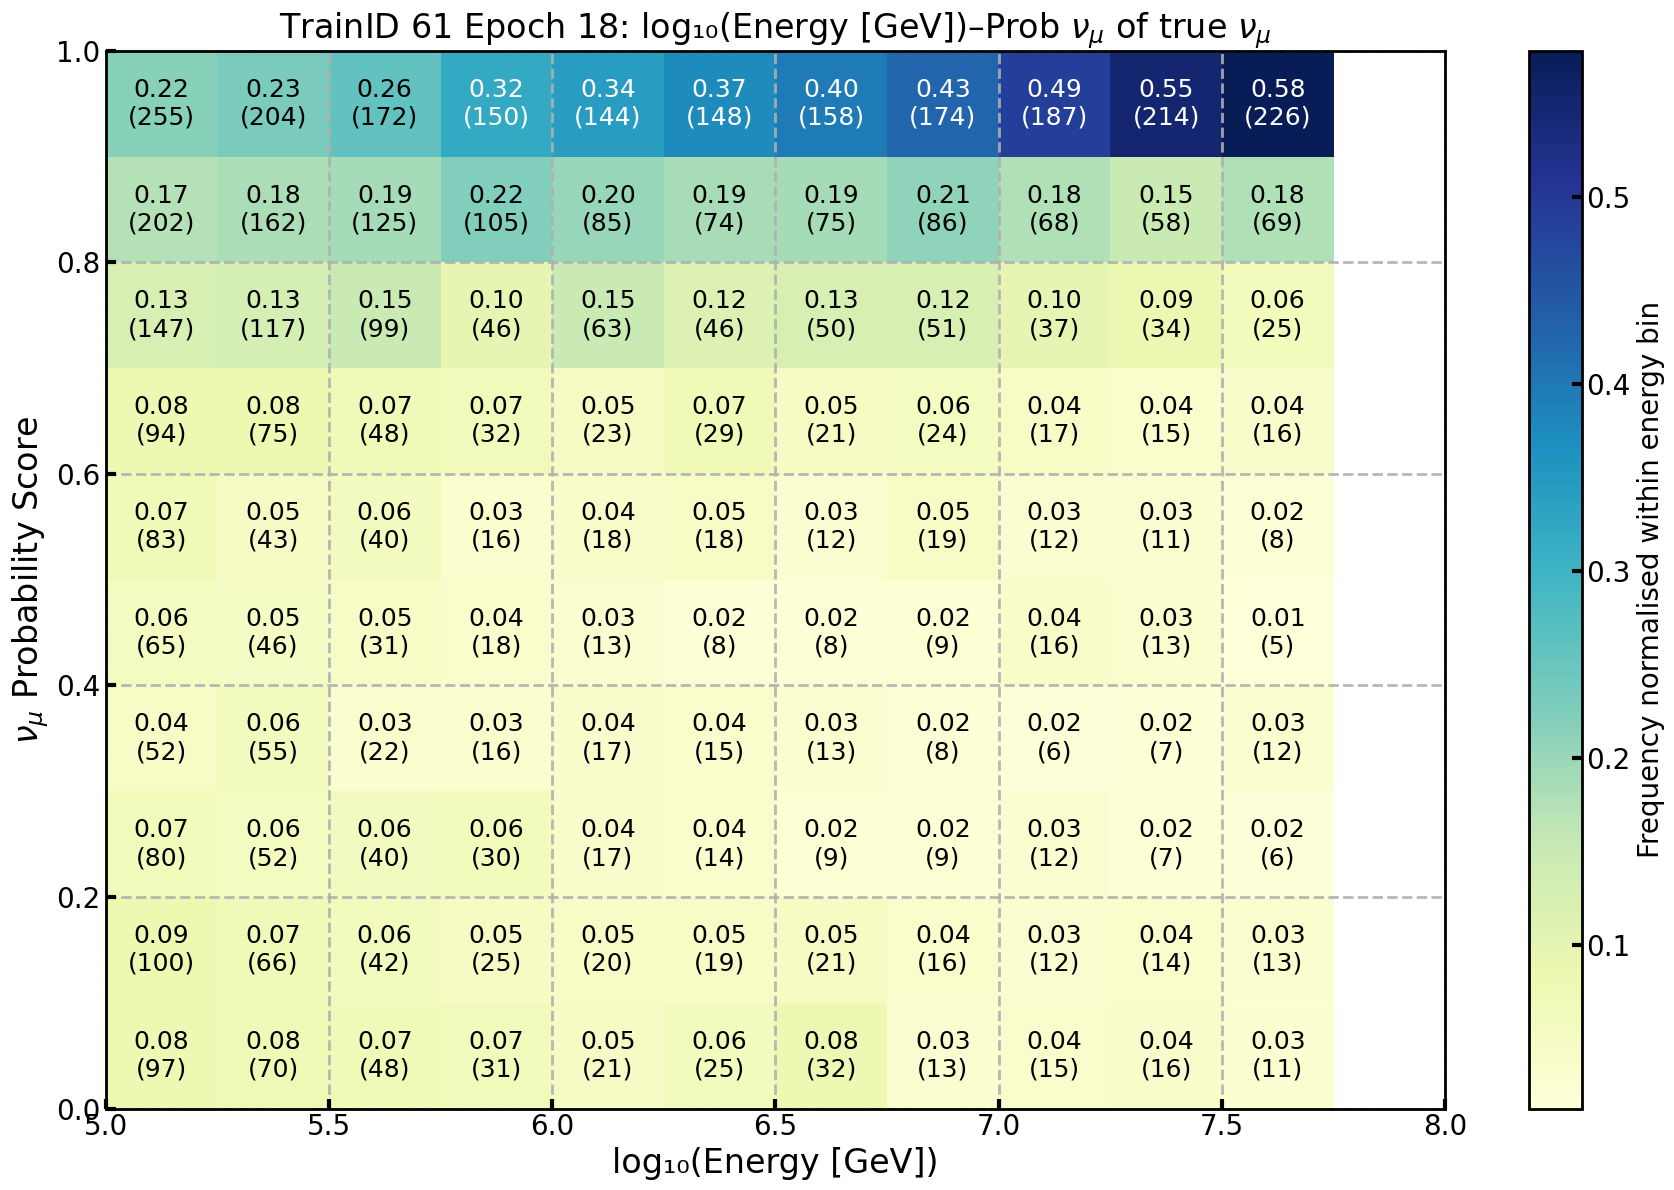

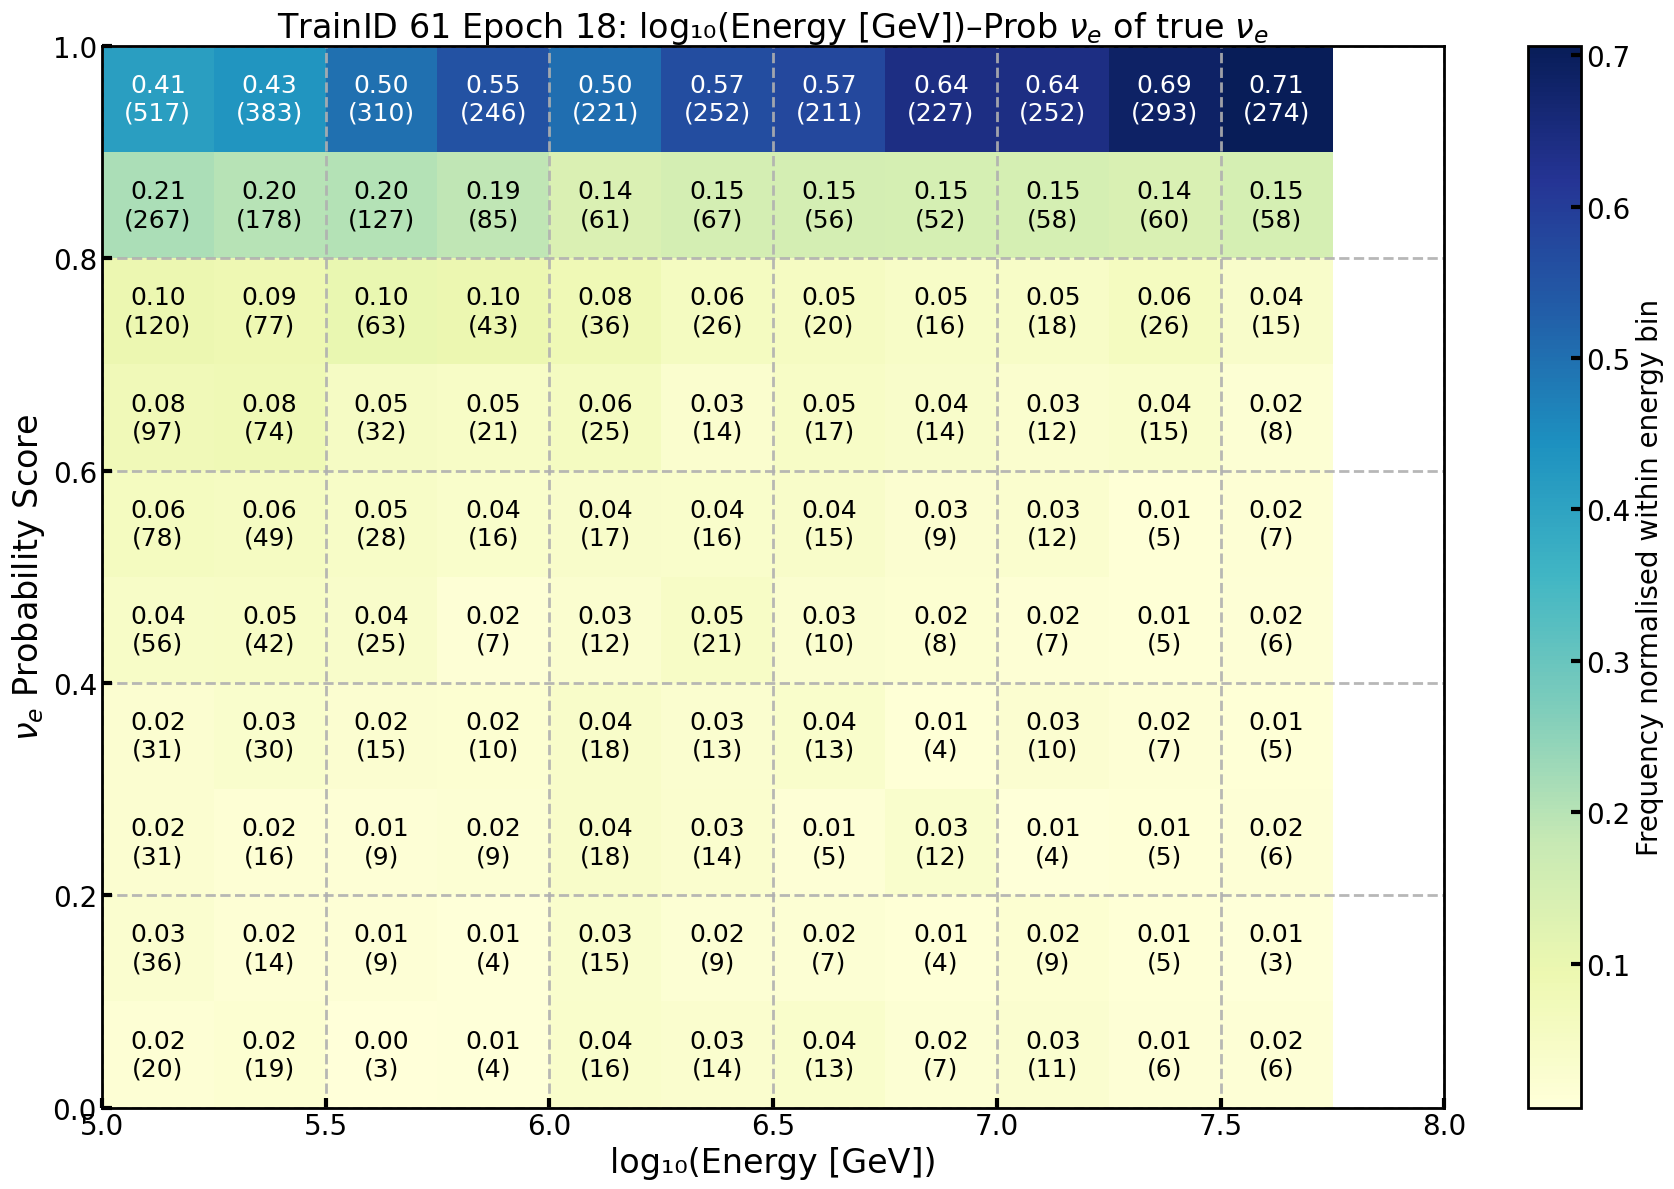

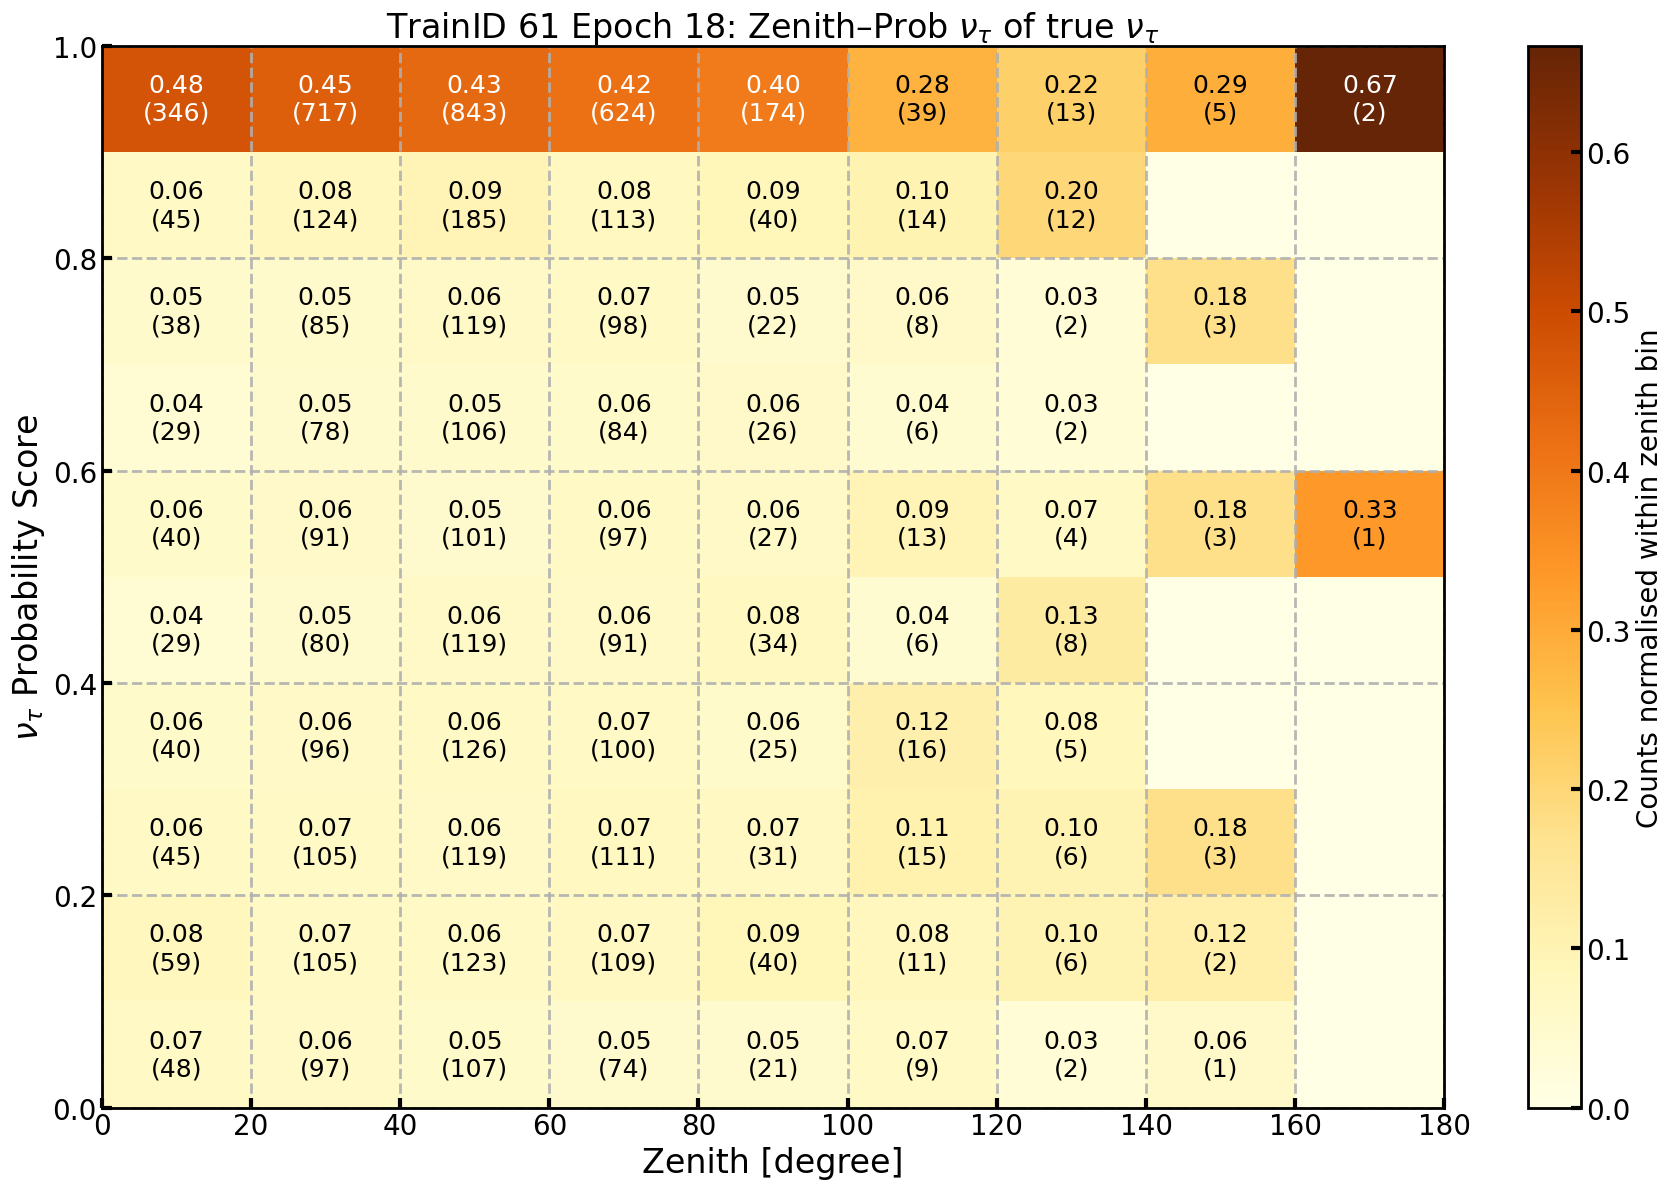

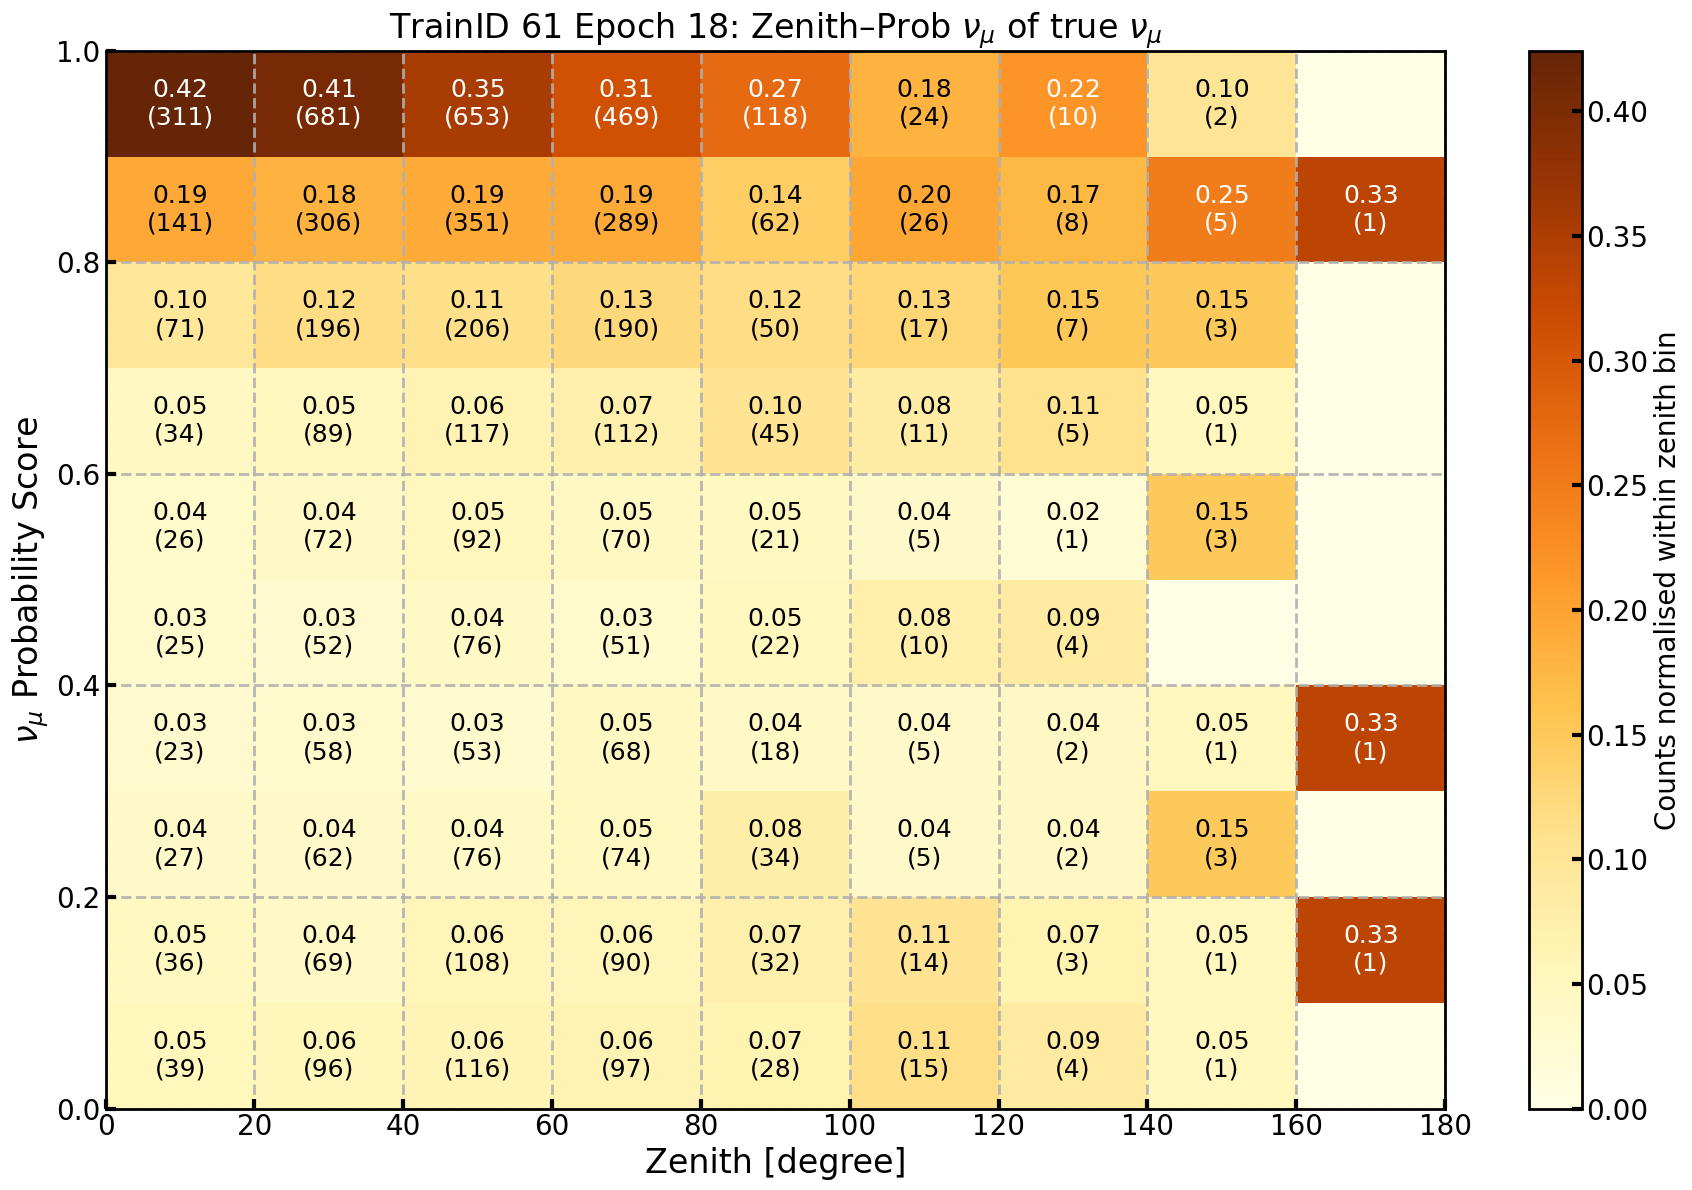

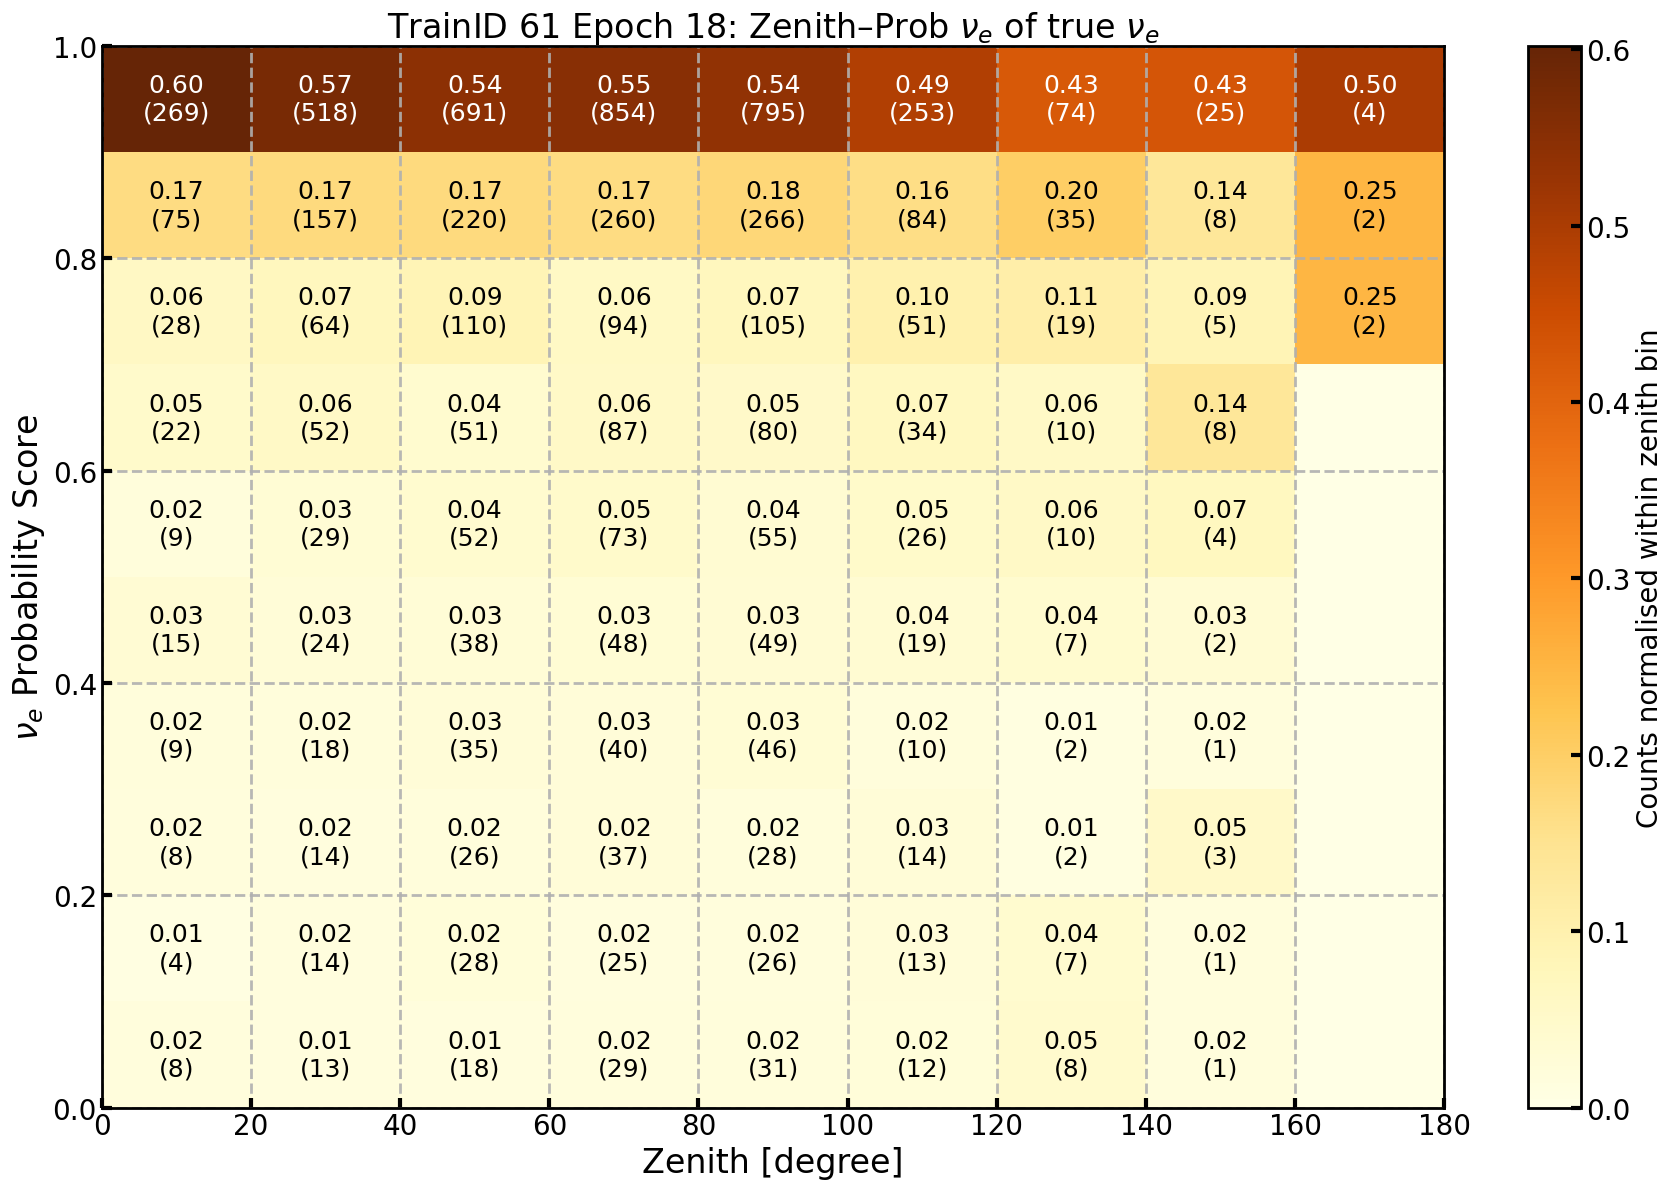

In [24]:
get_em_all(61, 18)

In [25]:
# get_em_all(61, 26)

In [26]:
# get_em_all(60, 18)